In [10]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

IMAGE_SIZE = 64
MAX_IMAGES_PER_CLASS = 200
PCA_COMPONENTS = 100
RANDOM_STATE = 42
train_dir = os.path.join("dataset", "New Plant Diseases Dataset(Augmented)", "train")
model_results = []

In [11]:
def binary_label(class_name):
    return 0 if "healthy" in class_name.lower() else 1


def load_images_binary(folder_path, max_images_per_class=200):
    images, labels = [], []
    for class_name in tqdm(os.listdir(folder_path), desc="Loading classes"):
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path):
            continue
        count = 0
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
                images.append(img)
                labels.append(binary_label(class_name))
                count += 1
                if max_images_per_class and count >= max_images_per_class:
                    break
            except:
                continue
    return np.array(images), np.array(labels)


def evaluate_model_custom_data(model, model_name, X_train, X_test, y_train, y_test):
    print(f"\n🔍 Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    model_results.append((model_name, acc))
    print(f"\n🎯 {model_name} Accuracy: {acc:.4f}\n")
    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Healthy", "Infected"]))

    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues",
                xticklabels=["Healthy", "Infected"], yticklabels=["Healthy", "Infected"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

In [12]:
X, y_binary = load_images_binary(train_dir, max_images_per_class=MAX_IMAGES_PER_CLASS)
X = X / 255.0
X_flattened = X.reshape(X.shape[0], -1)

print(f"\n✅ Loaded {X.shape[0]} images for Binary Classification")

print("\n🔻 Applying PCA to reduce dimensions...")
pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_flattened)

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(
    X_flattened, y_binary, test_size=0.2, random_state=RANDOM_STATE, stratify=y_binary
)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y_binary, test_size=0.2, random_state=RANDOM_STATE, stratify=y_binary
)

print(f" - Original Features: {X_train_normal.shape[1]} → PCA Features: {X_train_pca.shape[1]}")

Loading classes: 100%|██████████| 38/38 [00:05<00:00,  6.68it/s]



✅ Loaded 7600 images for Binary Classification

🔻 Applying PCA to reduce dimensions...
 - Original Features: 12288 → PCA Features: 100



🔍 Training Logistic Regression...

🎯 Logistic Regression Accuracy: 0.7763

📊 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.65      0.63      0.64       480
    Infected       0.83      0.84      0.84      1040

    accuracy                           0.78      1520
   macro avg       0.74      0.74      0.74      1520
weighted avg       0.77      0.78      0.78      1520



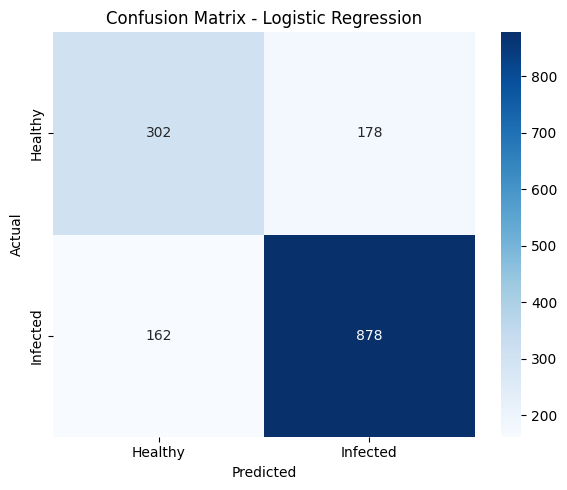

In [13]:
# 1. Logistic Regression
evaluate_model_custom_data(LogisticRegression(max_iter=1000), "Logistic Regression",X_train_normal, X_test_normal, y_train_normal, y_test_normal)


🔍 Training Decision Tree...

🎯 Decision Tree Accuracy: 0.7046

📊 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.53      0.54      0.54       480
    Infected       0.79      0.78      0.78      1040

    accuracy                           0.70      1520
   macro avg       0.66      0.66      0.66      1520
weighted avg       0.71      0.70      0.71      1520



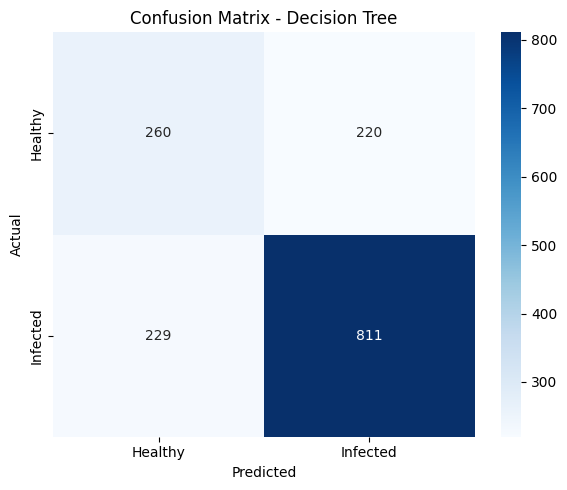

In [14]:
# 2. Decision Tree
evaluate_model_custom_data(DecisionTreeClassifier(random_state=RANDOM_STATE), "Decision Tree",X_train_normal, X_test_normal, y_train_normal, y_test_normal)


🔍 Training Random Forest...

🎯 Random Forest Accuracy: 0.8046

📊 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.80      0.51      0.62       480
    Infected       0.81      0.94      0.87      1040

    accuracy                           0.80      1520
   macro avg       0.80      0.73      0.75      1520
weighted avg       0.80      0.80      0.79      1520



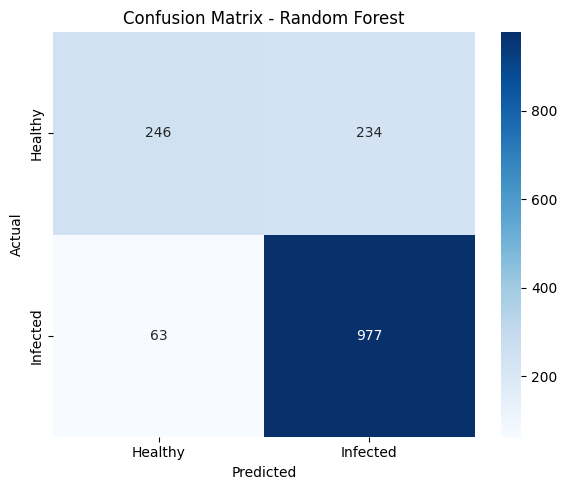

In [15]:
# 3. Random Forest
evaluate_model_custom_data(RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE), "Random Forest",X_train_normal, X_test_normal, y_train_normal, y_test_normal)


🔍 Training Support Vector Machine (PCA)...

🎯 Support Vector Machine (PCA) Accuracy: 0.8158

📊 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.76      0.61      0.68       480
    Infected       0.83      0.91      0.87      1040

    accuracy                           0.82      1520
   macro avg       0.80      0.76      0.77      1520
weighted avg       0.81      0.82      0.81      1520



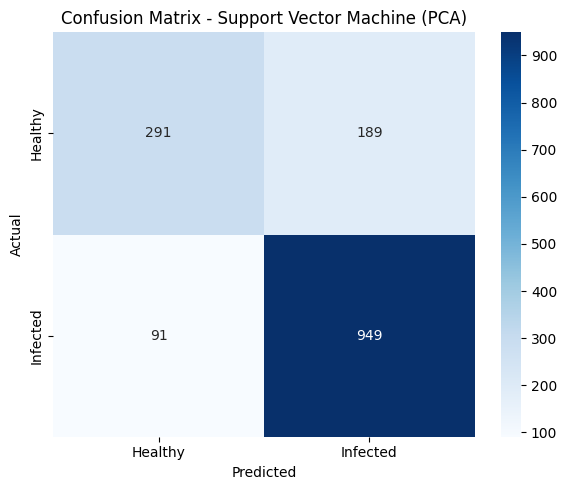

In [16]:
# 4. Support Vector Machine (PCA)
evaluate_model_custom_data(SVC(kernel='linear', probability=True), "Support Vector Machine (PCA)",X_train_pca, X_test_pca, y_train_pca, y_test_pca)


🔍 Training Naive Bayes (PCA)...

🎯 Naive Bayes (PCA) Accuracy: 0.6651

📊 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.47      0.47      0.47       480
    Infected       0.76      0.75      0.76      1040

    accuracy                           0.67      1520
   macro avg       0.61      0.61      0.61      1520
weighted avg       0.67      0.67      0.67      1520



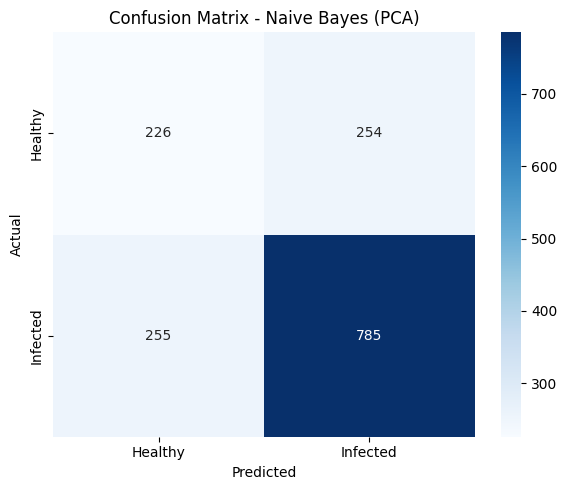

In [17]:
# 5. Naive Bayes (PCA)
evaluate_model_custom_data(GaussianNB(), "Naive Bayes (PCA)",X_train_pca, X_test_pca, y_train_pca, y_test_pca)

In [19]:
results_df = pd.DataFrame(model_results, columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("\n📋 Final Accuracy Summary:")
display(results_df.style.background_gradient(cmap="Greens").format({"Accuracy": "{:.2%}"}))


📋 Final Accuracy Summary:


,Model,Accuracy
0,Support Vector Machine (PCA),81.58%
1,Random Forest,80.46%
2,Logistic Regression,77.63%
3,Decision Tree,70.46%
4,Naive Bayes (PCA),66.51%
